In [1]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/tables"

/ocean/projects/cis240075p/asachan/.conda/envs/decoupler/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/objects/major_celltype_seurat.h5ad'
adata = sc.read_h5ad(adata_file)

In [3]:
adata

AnnData object with n_obs × n_vars = 40106 × 20513
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'log10GenesPerUMI', 'seurat_clusters', 'RNA_snn_res.0.6', 'cell_type', 'condition'
    var: 'highly_variable'
    uns: 'harmony', 'pca'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs', 'harmony'
    layers: 'counts'
    obsp: 'nn', 'snn'

In [4]:
# create a new obs for sex (take the first letter of the orig.ident)
adata.obs['sex'] = adata.obs['orig.ident'].str[0]

In [79]:
cell_type_colors = {
    'Fast IIB': '#FF9999',      # Light red/salmon
    'Fast IIX': '#99C2FF',      # Light blue
    'FAPs': '#99FFAB',          # Light green
    'EC': '#E5B3FF',            # Light purple
    'MTJ': '#FFB366',           # Light orange
    'Pericyte': '#FFE4B5',      # Gold
    'Skeleton MuSc': '#D4B499',  # Light brown
    'NMJ': '#FFB3D9',           # Light pink
    'Tendon': '#B3E6E6',        # Light cyan
    'Macrophages': '#CCCCCC'    # Light gray
}
condition_colors = {
    'WT': '#FFDAB9', # peachpuff
    'KO': '#008080'     # Teal (darker)
}
sex_colors = {
    'F': '#FFE4B5',   
    'M': '#B8860B'    
}

In [80]:
# Add the colors to adata
adata.uns['cell_type_colors'] = [cell_type_colors[cell_type] for cell_type in adata.obs['cell_type'].cat.categories]
adata.uns['condition_colors'] = [condition_colors[cond] for cond in adata.obs['condition'].cat.categories]
adata.uns['sex_colors'] = [sex_colors[sex] for sex in adata.obs['sex'].cat.categories]

[<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'condition'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sex'}, xlabel='UMAP1', ylabel='UMAP2'>]

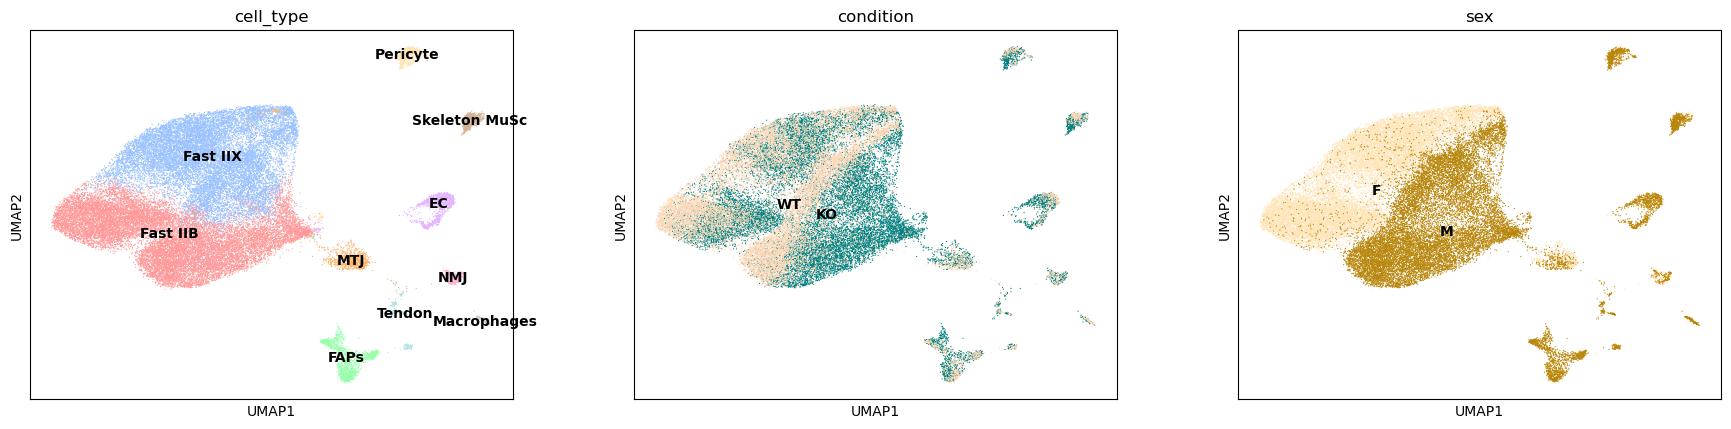

In [81]:
sc.pl.umap(adata, color=['cell_type', 'condition', 'sex'], legend_loc='on data', show=False)

[<Axes: title={'center': 'Δ ERCC1 KO cells'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sex'}, xlabel='UMAP1', ylabel='UMAP2'>]

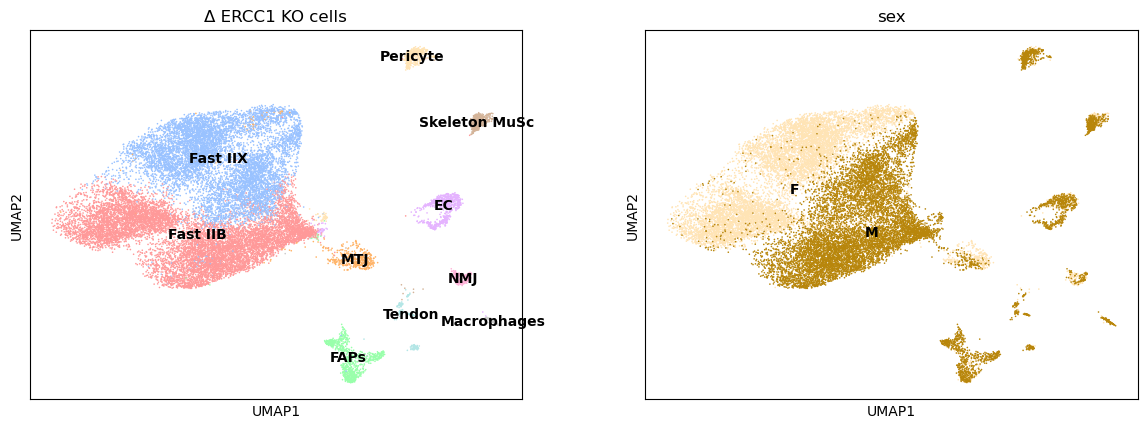

In [85]:
sc.pl.umap(adata[adata.obs['condition'] == 'KO'], color=['cell_type', 'sex'], legend_loc='on data', show=False, title='Δ ERCC1 KO cells')

[<Axes: title={'center': 'WT cells'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'sex'}, xlabel='UMAP1', ylabel='UMAP2'>]

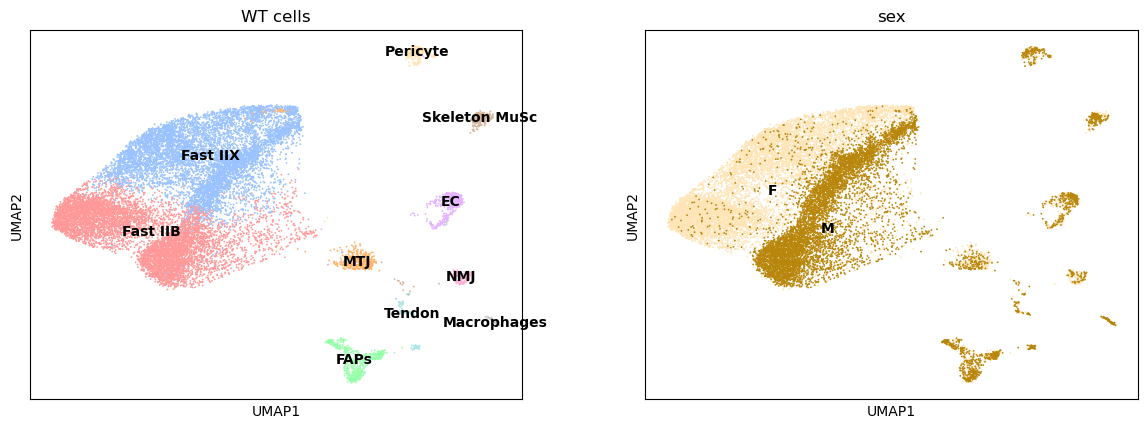

In [86]:
sc.pl.umap(adata[adata.obs['condition'] == 'WT'], color=['cell_type', 'sex'], legend_loc='on data', show=False, title='WT cells')

In [99]:
# save adata
adata.write_h5ad('/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/objects/major_celltype_seurat_v2.h5ad')

# Cell population depletion/expansion analysis

#### Cells pooled from both sexes

In [ ]:
results_df = get_cell_type_percentages(adata)
results_df_by_sex = get_cell_type_percentages_by_sex(adata)


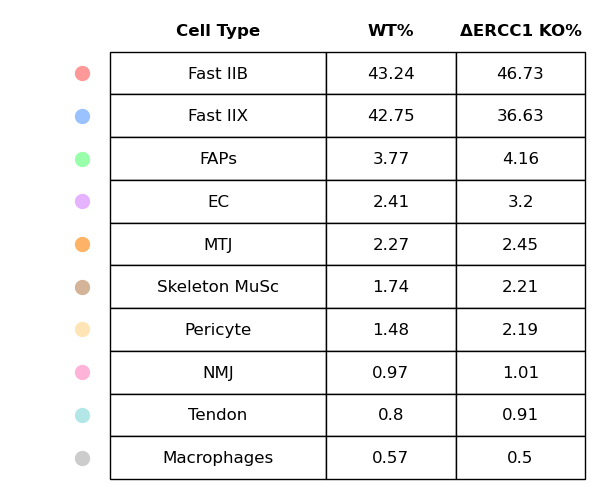

In [83]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))
ax.axis('off')

# Create table with more space on the left
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0.2, 0, 0.95, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
# Make headers bold and remove their edges
for col in range(len(results_df.columns)):
    header_cell = table[(0, col)]
    header_cell.set_text_props(weight='bold')
    header_cell.set_edgecolor('none')  # Remove cell borders for headers
    header_cell.set_facecolor('none')  # Remove cell background for headers
# Reduce row height and column width
for cell in table._cells:
    table._cells[cell].set_height(0.05)
    if cell[1] in [1, 2]:
        table._cells[cell].set_width(0.15)
    else:
        table._cells[cell].set_width(0.25)

# Add colored dots with correct y-positions
num_rows = len(results_df)
for idx in range(num_rows):
    cell_type = results_df['Cell Type'].iloc[idx]
    
    # Calculate y position from top to bottom
    y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
    ax.scatter(0.23,
              y_pos,
              c=[cell_type_colors.get(cell_type, 'black')],
              s=100,
              clip_on=False,
              zorder=1000)

# Set the plot limits explicitly to show the dots
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [100]:
# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 5))  # Made wider to accommodate more columns
# ax.axis('off')
# # Create table with more space on the left
# table = ax.table(cellText=results_df_by_sex.values,
#                 colLabels=results_df_by_sex.columns,
#                 cellLoc='center',
#                 loc='center',
#                 bbox=[0.2, 0, 0.95, 1])

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(12)

# # Make headers bold
# for col in range(len(results_df_by_sex.columns)):
#     header_cell = table[(0, col)]
#     header_cell.set_text_props(weight='bold')
#     header_cell.set_edgecolor('none')  # Remove cell borders for headers
#     header_cell.set_facecolor('none')  # Remove cell background for headers

# # Reduce row height and adjust column widths
# # Reduce row height and column width
# for cell in table._cells:
#     table._cells[cell].set_height(0.05)
#     if cell[1] in [1, 2, 3, 4]:
#         table._cells[cell].set_width(0.15)
#     else:
#         table._cells[cell].set_width(0.25)

# # Add colored dots
# num_rows = len(results_df_by_sex)
# for idx in range(num_rows):
#     cell_type = results_df_by_sex['Cell Type'].iloc[idx]
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[cell_type_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# ax.set_xlim(0.1, 1)
# ax.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

# [Analysis] Get the DEGs

In [ ]:
adata.X = adata.layers['log1p_norm_cb']

In [ ]:
# get the counts sum of genes starting with mt in different layers
mt_counts = adata.layers['counts'].toarray()[:, adata.var_names.str.startswith('mt-')]
mt_counts_cb = adata.layers['cellbender'].toarray()[:, adata.var_names.str.startswith('mt-')]
mt_counts_log1p_norm_cb = adata.layers['log1p_norm_cb'].toarray()[:, adata.var_names.str.startswith('mt-')]
print(mt_counts.sum())
print(mt_counts_cb.sum())
print(mt_counts_log1p_norm_cb.sum())

#### Filter non-nuclear genes

In [ ]:
# remove all genes that start with mt in all layers
adata = adata[:, ~adata.var_names.str.startswith('mt-')]
adata = adata[:, ~adata.var_names.str.startswith('Hbb-')]
adata = adata[:, ~adata.var_names.str.startswith('Hba-')]


In [ ]:
adata_male = adata[adata.obs['sex'] == 'M']
adata_female = adata[adata.obs['sex'] == 'F']

In [ ]:
output_dir = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/samples_2025/scanpy_outs'
# Set scanpy settings
sc.settings.verbosity = 1
sc.settings.figdir = output_dir

In [ ]:
# Analyze Male Cells
print("Analyzing Male Cells...")
adata_male_filtered, male_deg_results = perform_deg_analysis(
    adata_male, 
    condition_column='condition',
    reference='WT', 
    comparison='KO',
    sex_label='Male', #used for naming the files
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

# Analyze Female Cells  
print("Analyzing Female Cells...")
adata_female_filtered, female_deg_results = perform_deg_analysis(
    adata_female,
    condition_column='condition',
    reference='WT',
    comparison='KO', 
    sex_label='Female',
    output_dir=output_dir,
    layer='log1p_norm_cb'
)

In [ ]:
# Visualize and Save Results
if male_deg_results is not None:
    visualize_deg_results(male_deg_results, 'Male', output_dir)

if female_deg_results is not None:
    visualize_deg_results(female_deg_results, 'Female', output_dir)

In [ ]:
# save to csv
save_deg_results(male_deg_results, 'Male', output_dir)
save_deg_results(female_deg_results, 'Female', output_dir)


In [ ]:
display(male_deg_results)

In [ ]:
if male_deg_results is not None and female_deg_results is not None:
    # Find common and sex-specific DEGs
    male_sig_genes = set(male_deg_results[male_deg_results['significant']]['names'])
    female_sig_genes = set(female_deg_results[female_deg_results['significant']]['names'])
    
    common_genes = male_sig_genes.intersection(female_sig_genes)
    male_specific = male_sig_genes - female_sig_genes
    female_specific = female_sig_genes - male_sig_genes
    
    print(f"\n=== COMPARISON SUMMARY ===")
    print(f"Common DEGs in both sexes: {len(common_genes)}")
    print(f"Male-specific DEGs: {len(male_specific)}")
    print(f"Female-specific DEGs: {len(female_specific)}")
    
    # Save comparison results where the categories are the columns and the genes are the rows
    comparison_summary = pd.DataFrame({
        'Category': ['Common DEGs', 'Male-specific DEGs', 'Female-specific DEGs'],
        'Count': [len(common_genes), len(male_specific), len(female_specific)],
        'Genes': [common_genes, male_specific, female_specific]
    })
    
    comparison_file = 'DEG_sex_comparison_summary.csv'
    comparison_summary.to_csv(os.path.join(output_dir, comparison_file), index=False)
    print(f"Sex comparison summary saved at: {comparison_file}")

## Load pre-calculated DEGs

In [24]:
########## file paths ##########
output_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/seurat_outs/pathways"
#fast2b
female_fast2b_path = os.path.join(working_dir, "Female_FastIIB_unfiltered_KO_DEGs.csv")
male_fast2b_path = os.path.join(working_dir, "Male_Fast IIB_unfiltered_KO_DEGs_nmt.csv")
#fast2x
female_fast2x_path = os.path.join(working_dir, "Female_FastIIX_unfiltered_KO_DEGs.csv")
male_fast2x_path = os.path.join(working_dir, "Male_Fast IIX_unfiltered_KO_DEGs_nmt.csv")
# #faps
# female_faps_path = os.path.join(working_dir, "Female_FAPs_unfiltered_KO_DEGs_nmt.csv")
# male_faps_path = os.path.join(working_dir, "Male_FAPs_unfiltered_KO_DEGs_nmt.csv")
# #musc
# female_musc_path = os.path.join(working_dir, "Female_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")
# male_musc_path = os.path.join(working_dir, "Male_Skeleton MuSc_unfiltered_KO_DEGs_nmt.csv")


In [55]:
############ load cell-type specific DEGs ############

path_female_degs = female_fast2b_path
path_male_degs = male_fast2b_path
female_degs = pd.read_csv(path_female_degs, header=0)
female_degs.rename(columns={female_degs.columns[0]: 'gene_name'}, inplace=True)
male_degs = pd.read_csv(path_male_degs, header=0)
male_degs.rename(columns={male_degs.columns[0]: 'gene_name'}, inplace=True)

In [56]:
gsea_female_degs = create_ranked_genelist(female_degs)
gsea_male_degs = create_ranked_genelist(male_degs)

In [57]:
print(gsea_female_degs['Atp2a1'])

ranking_score    43.792006
Name: Atp2a1, dtype: float64


## Load the genesets of interest (mouse)

In [7]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"

In [9]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")

Number of unique genesets: 16059


In [10]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

### Select Pathways related to mitochondrial function

In [11]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords)
]

display(len(selected_pathways))

86

In [12]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

['GOBP_CALCIUM_ION_HOMEOSTASIS']

In [61]:
scores, norm, pvals = dc.run_gsea(
    gsea_male_degs,
    msigdb_mice[msigdb_mice["geneset"].isin(selected_pathways)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)
display(gsea_results.head())

,score,norm,pval
source,,,
GOBP_OXIDATIVE_PHOSPHORYLATION,0.918548,1.769351,0.000000
WP_APOPTOSIS,-0.937331,-1.609538,0.000000
HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.886939,1.750660,0.000000
WP_OXIDATIVE_PHOSPHORYLATION,0.912989,1.589818,0.013661
GOBP_NEGATIVE_REGULATION_OF_CALCIUM_ION_TRANSPORT,-0.922824,-1.509860,0.020934


In [62]:
# First prepare your data
# gsea_results = gsea_results[~gsea_results.index.str.startswith('WP')]
gsea_results['-log10(pval)'] = -np.log10(gsea_results['pval'].replace(0, 1e-300))
gsea_results['Group'] = gsea_results['score'].apply(lambda x: 'Up' if x > 0 else 'Down')
# Create a copy with reset index to get the pathway names as a column
plot_df = gsea_results.reset_index().copy()
plot_df[['Gene_set', 'Name']] = plot_df['source'].str.extract(r'(GOBP|REACTOME|KEGG|HALLMARK|GOMF|GOCC|GRAESSMANN|WP)_(.+)')
plot_df['Name'] = plot_df['Name'].apply(lambda x: '_'.join(x.split('_')[:6]))
plot_df = plot_df.loc[plot_df.groupby('Name')['-log10(pval)'].idxmax()]
# copy source column to a new column called 'Term'
plot_df['Term'] = plot_df['source']
display(plot_df.head())


,source,score,norm,pval,-log10(pval),Group,Gene_set,Name,Term
1,WP_APOPTOSIS,-0.937331,-1.609538,0.000000,300.000000,Down,WP,APOPTOSIS,WP_APOPTOSIS
48,GRAESSMANN_APOPTOSIS_BY_SERUM_DEPRIVATION_DN,0.457677,0.807961,0.729977,0.136691,Up,GRAESSMANN,APOPTOSIS_BY_SERUM_DEPRIVATION_DN,GRAESSMANN_APOPTOSIS_BY_SERUM_DEPRIVATION_DN
6,GOMF_CALCIUM_CHANNEL_ACTIVITY,-0.882441,-1.493431,0.023697,1.625312,Down,GOMF,CALCIUM_CHANNEL_ACTIVITY,GOMF_CALCIUM_CHANNEL_ACTIVITY
51,GOCC_CALCIUM_CHANNEL_COMPLEX,-0.431513,-0.713143,0.848819,0.071185,Down,GOCC,CALCIUM_CHANNEL_COMPLEX,GOCC_CALCIUM_CHANNEL_COMPLEX
25,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY,0.782114,1.233718,0.269461,0.569504,Up,GOMF,CALCIUM_CHANNEL_REGULATOR_ACTIVITY,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY


## Plotting the enrichment results

In [21]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

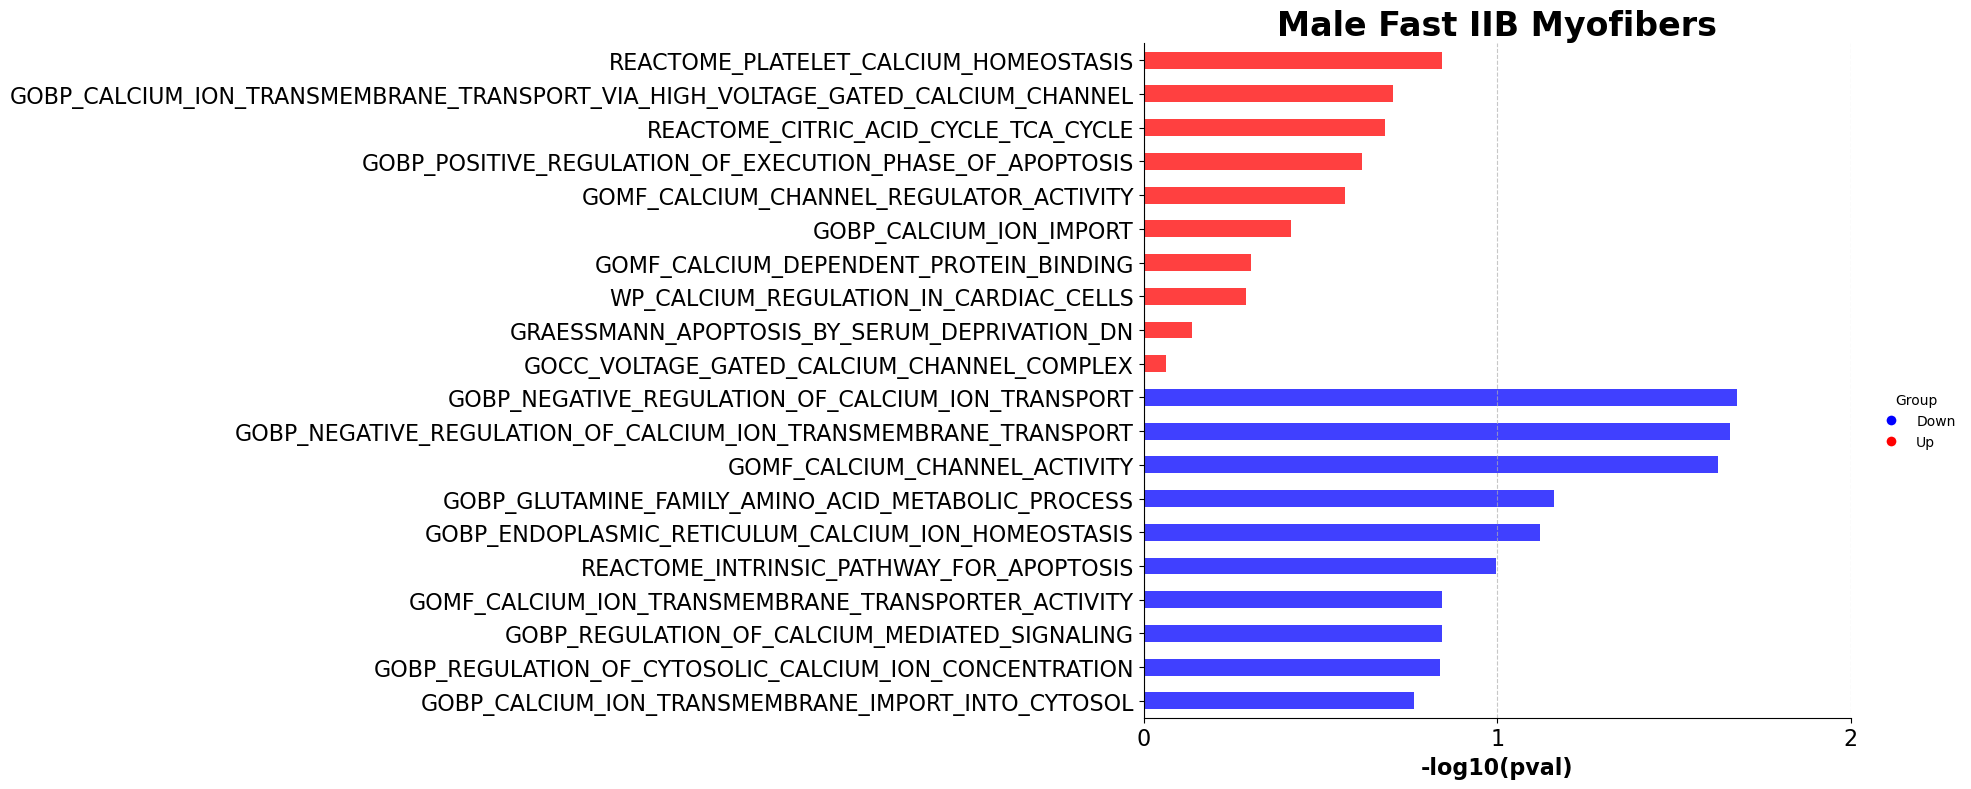

In [ ]:
# Create simplified terms and group by them
plot_df['simple_term'] = plot_df['Term'].apply(simplify_term)
# Keep only the most significant pathway for each simplified term
plot_df = plot_df.loc[plot_df.groupby('simple_term')['-log10(pval)'].idxmax()]
# Sort to put Up group at top
plot_df = plot_df.sort_values(['Group', '-log10(pval)'], ascending=[True, False])

ax = gp.barplot(
    df=plot_df,
    column='-log10(pval)',
    group='Group',
    title='Male Fast IIB Myofibers',
    color={'Up': 'red', 'Down': 'blue'},
    cutoff=2.0,
    figsize=(14, 8)
)

# Set x-axis limits and ticks
ax.set_xlim(0, 2)  # Fixed limit to 2.5
ax.set_xticks([0, 1, 2])  # Only show 0, 1, and 2
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()

In [50]:
cutoff_for_plotting_data = plot_df[plot_df['-log10(pval)'] <= 2][['Term', 'Group', '-log10(pval)']]
top_paths = (cutoff_for_plotting_data.groupby('Group')
            .apply(lambda x: x.nlargest(min(10, len(x)), '-log10(pval)'))
            .reset_index(drop=True))

# Sort by Group (to keep Up on top) and then by -log10(pval)
top_paths = top_paths.sort_values(['Group', '-log10(pval)'], ascending=[True, False])
display(top_paths)


/tmp/ipykernel_70828/3318314552.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(min(10, len(x)), '-log10(pval)'))


,Term,Group,-log10(pval)
0,WP_TCA_CYCLE,Down,1.057539
1,REACTOME_INTRINSIC_PATHWAY_FOR_APOPTOSIS,Down,0.858838
2,HALLMARK_APOPTOSIS,Down,0.669007
3,GOBP_POSITIVE_REGULATION_OF_CYTOSOLIC_CALCIUM_...,Down,0.466321
4,GOBP_NEGATIVE_REGULATION_OF_CALCIUM_ION_TRANSM...,Down,0.424943
5,GOBP_CALCIUM_ION_TRANSMEMBRANE_IMPORT_INTO_CYT...,Down,0.181477
6,GOBP_CALCIUM_ION_TRANSMEMBRANE_TRANSPORT_VIA_H...,Up,0.886057
7,GOBP_OXIDATIVE_PHOSPHORYLATION,Up,0.758046
8,GOMF_CALCIUM_CHANNEL_REGULATOR_ACTIVITY,Up,0.594801
9,GOCC_CALCIUM_CHANNEL_COMPLEX,Up,0.565076


In [51]:
geneset_genes = get_geneset_genes(top_paths, msigdb_mice, f'{output_dir}/male_fast2x_top_10_pathways.csv')